### 逻辑回归-线性不可分
案例：判断芯片要接受还是抛弃

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path='ex2data2.txt'
data=pd.read_csv(path,names=['Test 1','Test 2','Accepted'])
data.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


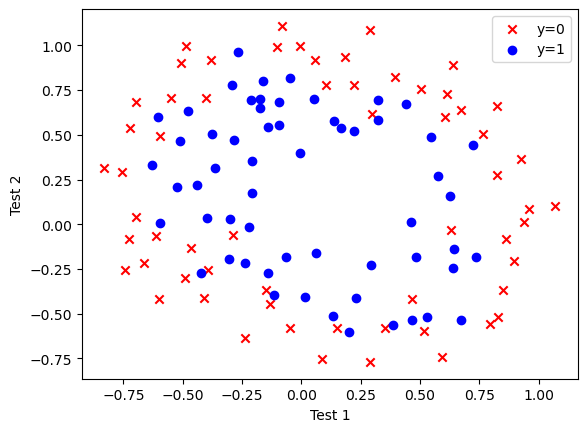

In [3]:
fig,ax=plt.subplots()
ax.scatter(data[data['Accepted']==0]['Test 1'],data[data['Accepted']==0]['Test 2'],c='r',marker='x',label='y=0')
ax.scatter(data[data['Accepted']==1]['Test 1'],data[data['Accepted']==1]['Test 2'],c='b',marker='o',label='y=1')
ax.legend()
ax.set(xlabel='Test 1',ylabel='Test 2')
plt.show()

### 特征映射
将一个二维特征(x1, x2)根据自己的需要映射到高维

例如2次方
$$
\left\{
\begin{matrix}
1 \\
x_1 \\
x_2 \\
x_1^2 \\
x_1x_2 \\
x_2^2
\end{matrix}
\right\}
$$


In [20]:
def feature_mapping(x1,x2,power):
    data={}

    for i in range(power+1):
        for j in range(i+1):
            data['F{}{}'.format(i-j,j)]=np.power(x1,i-j)*np.power(x2,j)
    return pd.DataFrame(data)

In [13]:
x1=data['Test 1']
x2=data['Test 2']

In [21]:
data2=feature_mapping(x1,x2,6)#映射为6次方

$$Fij=x_1^ix_2^j$$

In [9]:
data2.head()

,F00,F10,F01,F20,F11,F02,F30,F21,F12,F03,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


### 构造数据集

In [10]:
X=data2.values
X.shape

(118, 28)

In [11]:
y=data.iloc[:,-1].values
y=y.reshape(len(y),1)
y.shape

(118, 1)

#### 代价函数
L1正则化
$$
\frac{\lambda}{2m}\sum_{j=1}^{n}|θ_j|
$$
L2正则化
$$
\frac{\lambda}{2m}\sum_{j=1}^{n}θ_j^2
$$
代价函数
$$
J(θ)=-\frac{1}{m}[\sum_{i=1}^{m} y^{(i)}logh_θ(x^{(i)})+(1-y^{(i)})log(1-h_θ(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^{n}θ_j^2
$$

$\lambda$越小，过拟合

$\lambda$越大，欠拟合

In [22]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [27]:
def costFunction(X,y,theta,lamda):
    A=sigmoid(X@theta)
    first=y*np.log(A)
    second=(1-y)*np.log(1-A)
    reg=np.sum(np.power(theta[1:],2))*lamda/(2*len(X))

    return -np.sum(first+second)/len(X)+reg

In [24]:
theta=np.zeros((28,1))

In [28]:
lamda=1

In [29]:
cost_init=costFunction(X,y,theta,lamda)

In [30]:
print(cost_init)

0.6931471805599454


### 梯度下降

$$
\frac{\partial{J(θ)}}{\partial{θ_j}} = \frac{1}{m} \sum_{i=1}^{m}(h_θ(x^{(i)})-y^{(i)})x_j^{(i)}\tag{for j = 0}
$$

$$
\frac{\partial{J(θ)}}{\partial{θ_j}} = \frac{1}{m} \sum_{i=1}^{m}(h_θ(x^{(i)})-y^{(i)})x_j^{(i)}+\frac\lambda m θ_j\tag{for j >= 1}
$$

In [31]:
def gradientDescent(X,y,theta,alpha,iters,lamba):
    costs=[]

    for i in range(iters):
        reg=theta[1:]*lamda/len(X)#因为从j=1开始，所以会少一行
        reg=np.insert(reg,0,values=0,axis=0)#为了对齐，多加入一行0
        theta=theta-(X.T@(sigmoid(X@theta)-y))*alpha/len(X)-reg
        cost=costFunction(X,y,theta,lamda)
        costs.append(cost)
    return theta,costs

In [32]:
alpha=0.001
iters=200000
lamda=0.001
theta_final,costs=gradientDescent(X,y,theta,alpha,iters,lamda)

In [33]:
def predict(X,theta):
    prob=sigmoid(X@theta)
    return [1 if x>=0.5 else 0 for x in prob]

In [34]:
y_=np.array(predict(X,theta_final))
y_pre=y_.reshape(len(y_),1)

acc=np.mean(y_pre==y)
print(acc)

0.8305084745762712


### 决策界面

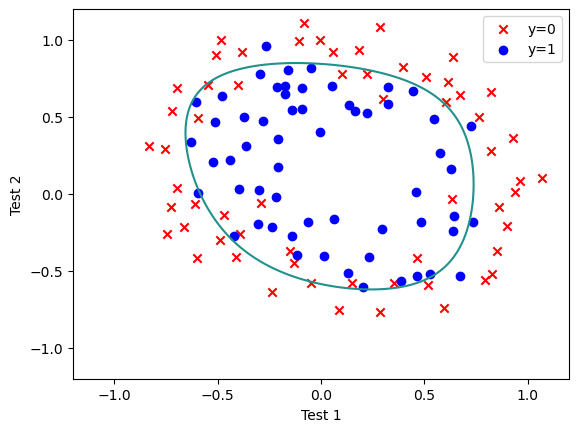

In [35]:
x=np.linspace(-1.2,1.2,200)
xx,yy=np.meshgrid(x,x)
z=feature_mapping(xx.ravel(),yy.ravel(),6).values #ravel拉成向量
zz=z@theta_final
zz=zz.reshape(xx.shape)

fig,ax=plt.subplots()
ax.scatter(data[data['Accepted']==0]['Test 1'],data[data['Accepted']==0]['Test 2'],c='r',marker='x',label='y=0')
ax.scatter(data[data['Accepted']==1]['Test 1'],data[data['Accepted']==1]['Test 2'],c='b',marker='o',label='y=1')
ax.legend()
ax.set(xlabel='Test 1',ylabel='Test 2')
plt.contour(xx,yy,zz,0)# 等高线
plt.show()